In [1]:
import copy
from pathlib import Path
import warnings

import torch
import numpy as np
import pandas as pd

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [2]:
data = pd.read_pickle('../M5_Dataset/tft_dataset.pkl')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135870 entries, 0 to 135869
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   store_id      135870 non-null  category      
 1   dept_id       135870 non-null  category      
 2   state_id      135870 non-null  category      
 3   cat_id        135870 non-null  category      
 4   Node          135870 non-null  category      
 5   d             135870 non-null  int16         
 6   sold          135870 non-null  float64       
 7   date          135870 non-null  datetime64[ns]
 8   weekday       135870 non-null  category      
 9   wday          135870 non-null  category      
 10  month         135870 non-null  category      
 11  event_name_1  135870 non-null  category      
 12  event_type_1  135870 non-null  category      
 13  event_name_2  135870 non-null  category      
 14  event_type_2  135870 non-null  category      
 15  snap_CA       135

In [4]:
data["month"] = data["month"].astype(str).astype("category")

In [5]:
max_prediction_length = 30
max_encoder_length = 90
training_cutoff = data["d"].max() - max_prediction_length

In [6]:
special_days = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
snap_days = ['snap_CA', 'snap_TX', 'snap_WI']

In [7]:
data[snap_days] = data[snap_days].astype(str).astype("category")

In [8]:
dataset = TimeSeriesDataSet(
    data[lambda x: x.d <= training_cutoff],
    time_idx="d",
    target="sold",
    group_ids=["Node"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["Node", "store_id", "dept_id", "state_id", 'cat_id'],
    time_varying_known_categoricals=["special_days", "month", "snap_days"],
    variable_groups={"special_days": special_days, "snap_days": snap_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["d"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["sold"],

    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True
)

In [9]:
dataset.get_parameters()

{'time_idx': 'd',
 'target': 'sold',
 'group_ids': ['Node'],
 'weight': None,
 'max_encoder_length': 90,
 'min_encoder_length': 45,
 'min_prediction_idx': 1,
 'min_prediction_length': 1,
 'max_prediction_length': 30,
 'static_categoricals': ['Node', 'store_id', 'dept_id', 'state_id', 'cat_id'],
 'static_reals': ['encoder_length', 'sold_center', 'sold_scale'],
 'time_varying_known_categoricals': ['special_days', 'month', 'snap_days'],
 'time_varying_known_reals': ['d', 'relative_time_idx'],
 'time_varying_unknown_categoricals': [],
 'time_varying_unknown_reals': ['sold'],
 'variable_groups': {'special_days': ['event_name_1',
   'event_type_1',
   'event_name_2',
   'event_type_2'],
  'snap_days': ['snap_CA', 'snap_TX', 'snap_WI']},
 'constant_fill_strategy': {},
 'allow_missing_timesteps': False,
 'lags': {},
 'add_relative_time_idx': True,
 'add_target_scales': True,
 'add_encoder_length': True,
 'target_normalizer': EncoderNormalizer(),
 'categorical_encoders': {'__group_id__Node': Na

In [10]:
validation = TimeSeriesDataSet.from_dataset(dataset, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128
train_dataloader = dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=0, shuffle=True)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size , num_workers=0)

In [15]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    dataset,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=64,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=4,
    dropout=0.3,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Number of parameters in network: 226.5k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.8 K 
3  | prescalers                         | ModuleDict                      | 96    
4  | static_variable_selection          | VariableSelectionNetwork        | 6.6 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 6.3 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 4.5 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 16.8 K
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 16.8 K
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 16.8

Finding best initial lr: 100%|██████████| 100/100 [01:11<00:00,  1.37it/s]Restored states from the checkpoint file at /Users/juhyeonkim/Dropbox/내 Mac (JuHyeonui-iMac.local)/Documents/graphNN/graphNN/lr_find_temp_model.ckpt


suggested learning rate: 0.0019498445997580445


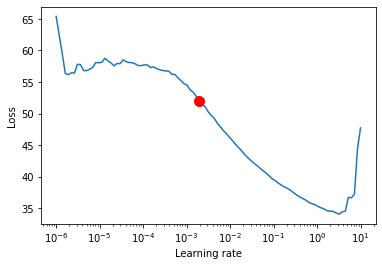

<ipython-input-16-a92b5627800b>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [16]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [17]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=60,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    dataset,
    learning_rate=0.0019498445997580445,
    hidden_size=64,
    attention_head_size=4,
    dropout=0.3,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Number of parameters in network: 226.5k


In [18]:
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.8 K 
3  | prescalers                         | ModuleDict                      | 96    
4  | static_variable_selection          | VariableSelectionNetwork        | 6.6 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 6.3 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 4.5 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 16.8 K
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 16.8 K
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 16.8

Validation sanity check:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/pytorch_forecasting/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Global seed set to 42
/opt/anaconda3/envs/pytorch_forecasting/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:   0%|          | 0/31 [00:00<?, ?it/s] 

Finding best initial lr: 100%|██████████| 100/100 [01:49<00:00,  1.10s/it]


Epoch 0: 100%|██████████| 31/31 [00:23<00:00,  1.34it/s, loss=55, v_num=4, val_loss=70.30, train_loss_step=53.30]  
Validating: 0it [00:00, ?it/s]
Epoch 1:   0%|          | 0/31 [00:00<?, ?it/s, loss=55, v_num=4, val_loss=55.30, train_loss_step=51.20, train_loss_epoch=56.00]         

/opt/anaconda3/envs/pytorch_forecasting/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:610: LightningDeprecationWarning: Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2 and will be removed in v1.4. Please, create your own `mc = ModelCheckpoint(monitor='your_monitor')` and use it as `Trainer(callbacks=[mc])`.
  warning_cache.deprecation(


Epoch 1: 100%|██████████| 31/31 [00:24<00:00,  1.25it/s, loss=39.1, v_num=4, val_loss=55.30, train_loss_step=34.30, train_loss_epoch=56.00]
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 31/31 [00:21<00:00,  1.43it/s, loss=29.3, v_num=4, val_loss=37.00, train_loss_step=24.30, train_loss_epoch=42.20]
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 31/31 [00:21<00:00,  1.42it/s, loss=25.9, v_num=4, val_loss=29.40, train_loss_step=26.10, train_loss_epoch=31.00]
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 31/31 [00:22<00:00,  1.38it/s, loss=25.2, v_num=4, val_loss=28.00, train_loss_step=25.70, train_loss_epoch=25.70]
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 31/31 [00:21<00:00,  1.42it/s, loss=25.3, v_num=4, val_loss=28.10, train_loss_step=26.60, train_loss_epoch=25.10]
Validating: 0it [00:00, ?it/s]
Epoch 6: 100%|██████████| 31/31 [00:21<00:00,  1.42it/s, loss=24.3, v_num=4, val_loss=28.10, train_loss_step=26.10, train_loss_epoch=24.80]
Valid

Epoch 23: 100%|██████████| 31/31 [00:23<00:00,  1.29it/s, loss=22.2, v_num=4, val_loss=26.80, train_loss_step=20.70, train_loss_epoch=22.60]
Validating: 0it [00:00, ?it/s]
Epoch 24: 100%|██████████| 31/31 [00:21<00:00,  1.43it/s, loss=23.3, v_num=4, val_loss=27.00, train_loss_step=28.90, train_loss_epoch=22.00]
Validating: 0it [00:00, ?it/s]
Epoch 25: 100%|██████████| 31/31 [00:29<00:00,  1.03it/s, loss=23.7, v_num=4, val_loss=27.30, train_loss_step=22.90, train_loss_epoch=23.00]
Validating: 0it [00:00, ?it/s]
Epoch 26: 100%|██████████| 31/31 [00:22<00:00,  1.40it/s, loss=23.2, v_num=4, val_loss=26.80, train_loss_step=20.70, train_loss_epoch=23.10]
Validating: 0it [00:00, ?it/s]
Epoch 27: 100%|██████████| 31/31 [00:22<00:00,  1.39it/s, loss=22.2, v_num=4, val_loss=26.60, train_loss_step=19.40, train_loss_epoch=22.80]
Validating: 0it [00:00, ?it/s]
Epoch 28: 100%|██████████| 31/31 [00:22<00:00,  1.38it/s, loss=23.3, v_num=4, val_loss=27.40, train_loss_step=25.60, train_loss_epoch=22.40]

In [19]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [20]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(100.4258)

In [21]:
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

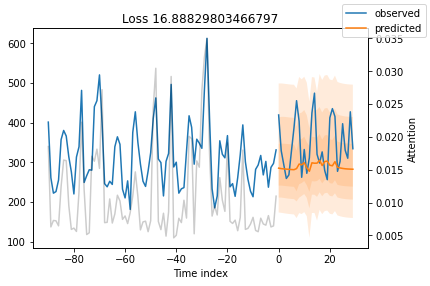

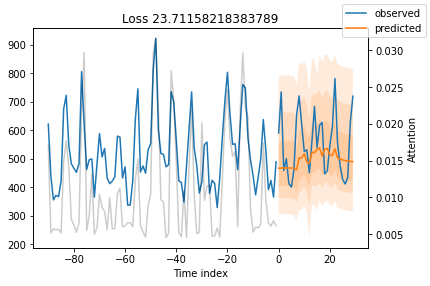

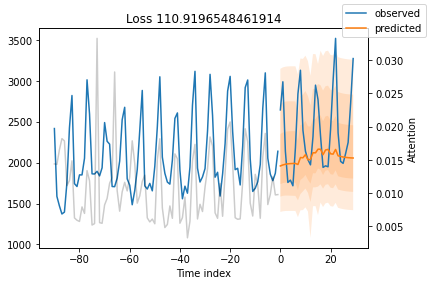

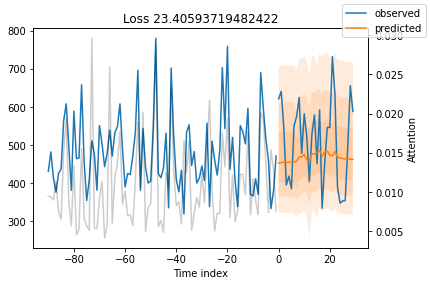

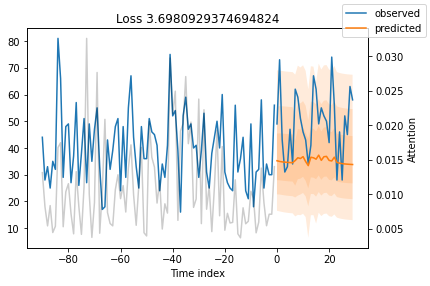

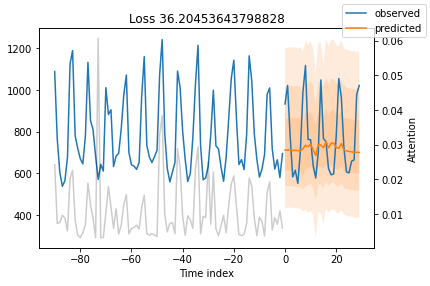

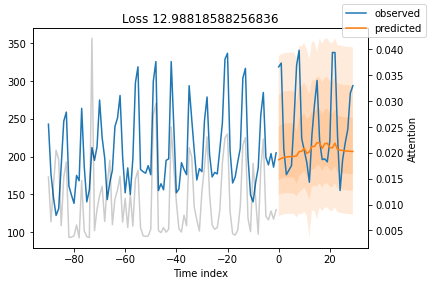

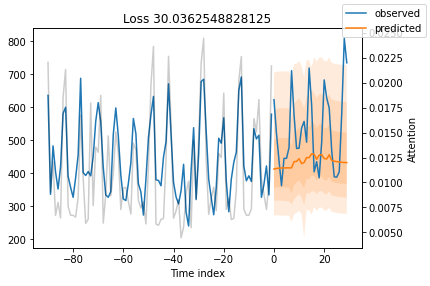

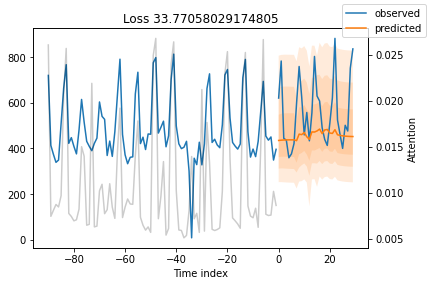

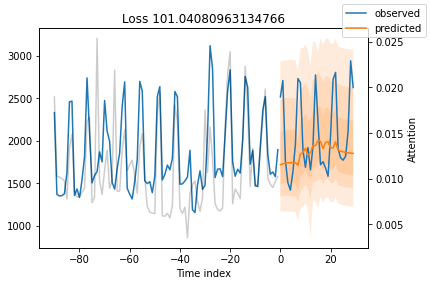

In [22]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

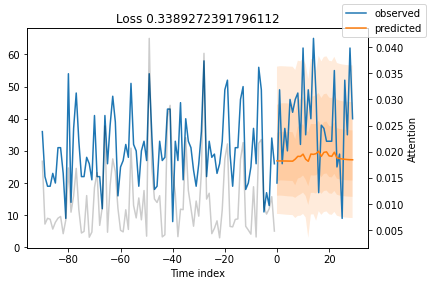

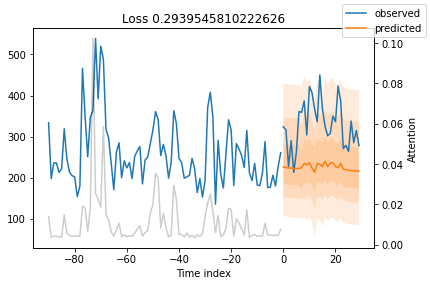

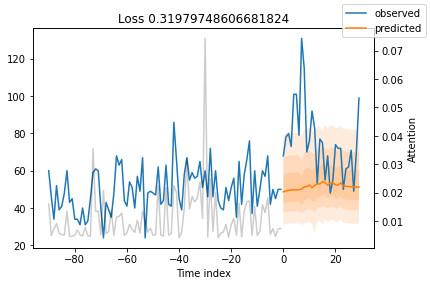

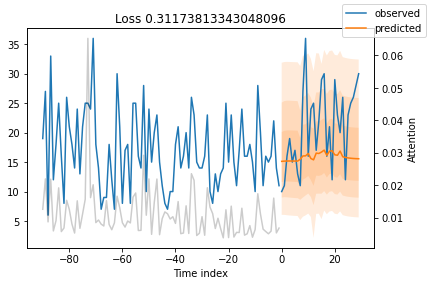

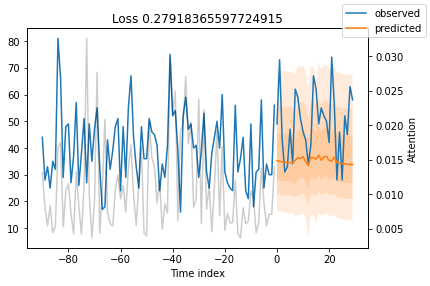

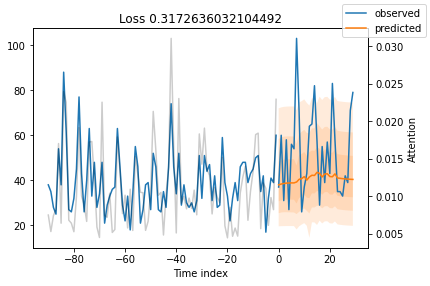

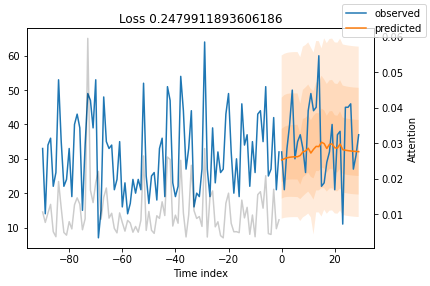

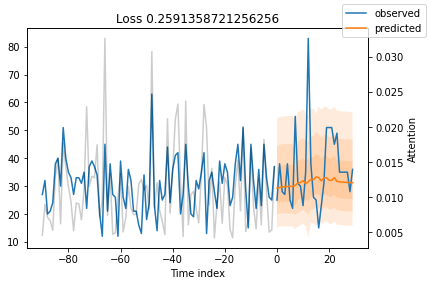

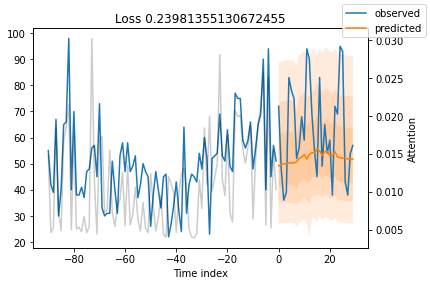

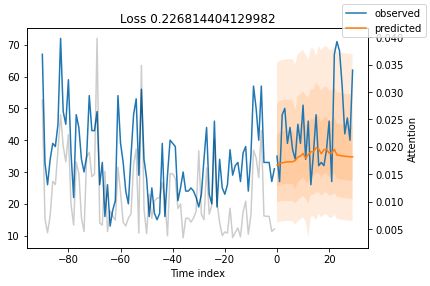

In [23]:
# calcualte metric by which to display
predictions = best_tft.predict(val_dataloader)
mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles)
    );

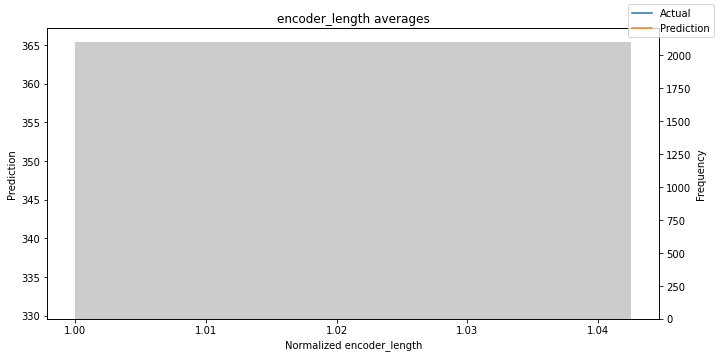

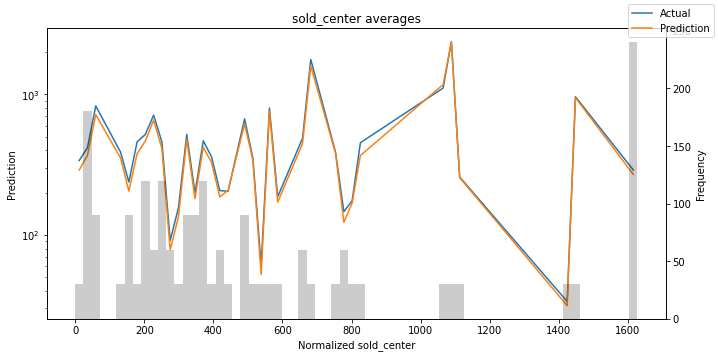

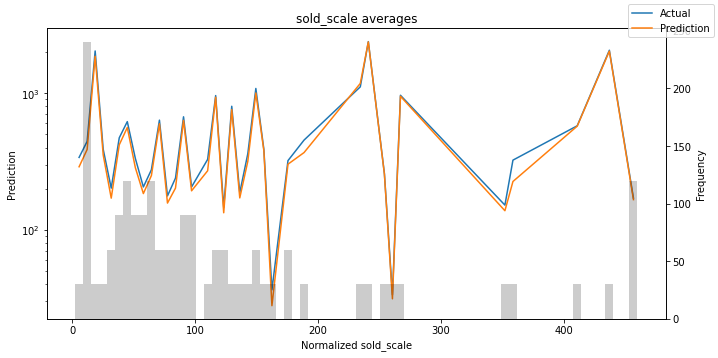

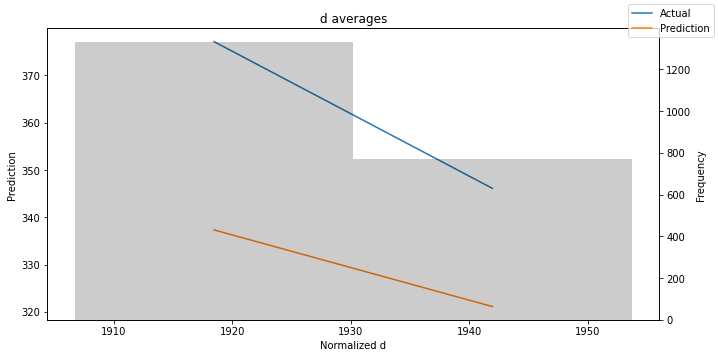

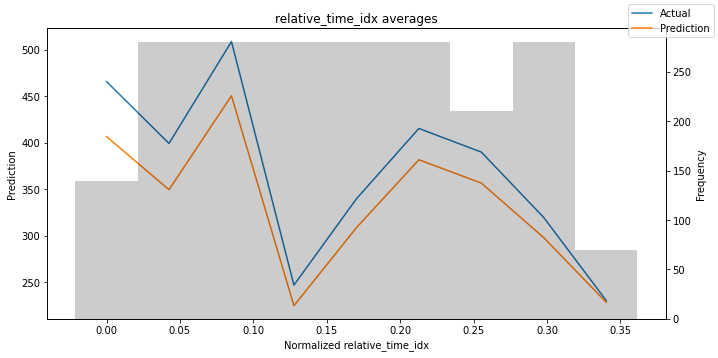

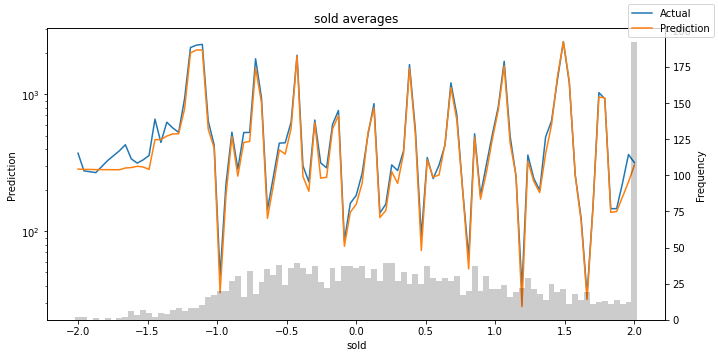

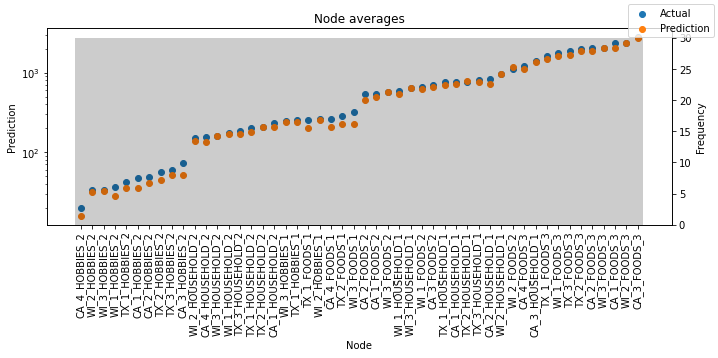

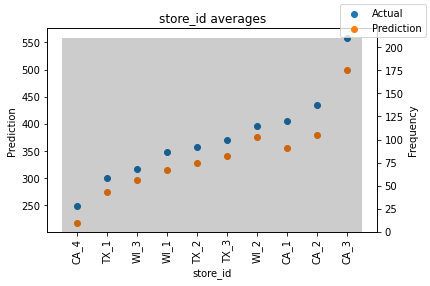

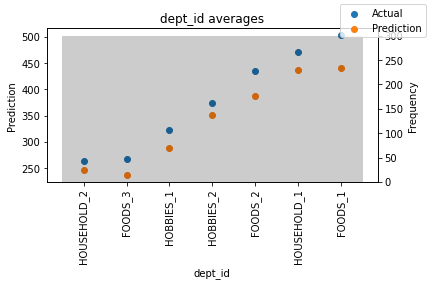

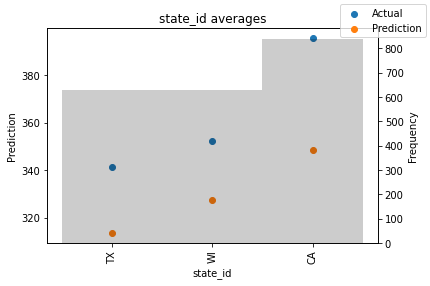

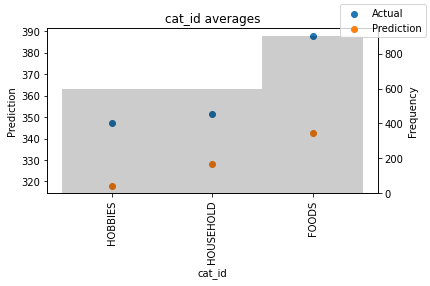

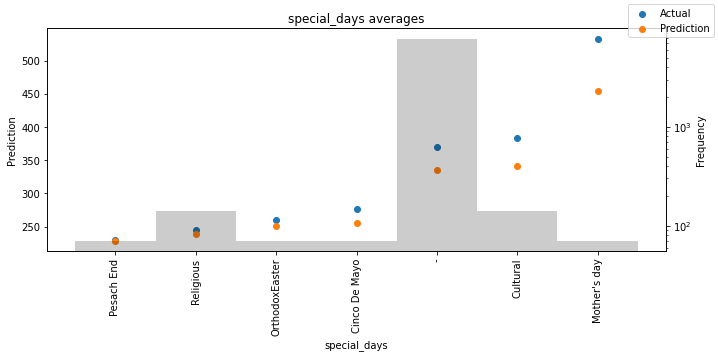

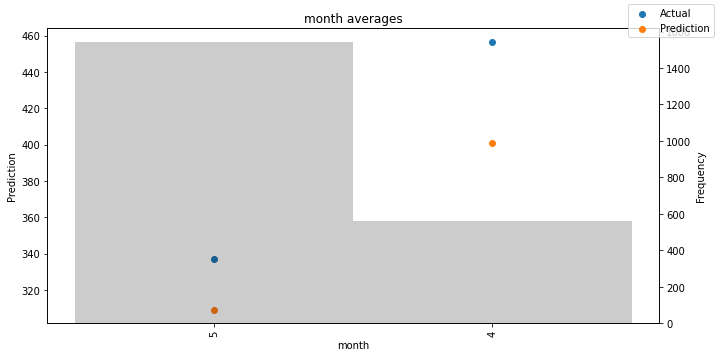

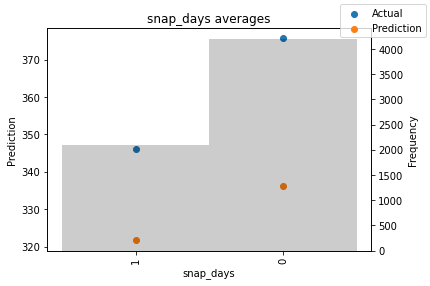

In [24]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x288 with 1 Axes>,
 'encoder_variables': <Figure size 504x252 with 1 Axes>,
 'decoder_variables': <Figure size 504x234 with 1 Axes>}

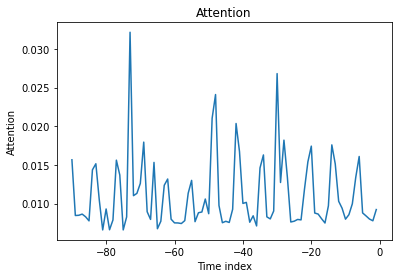

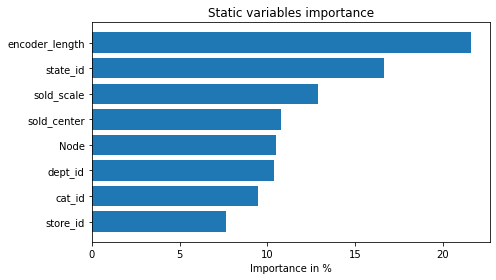

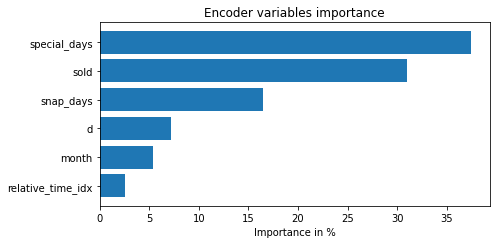

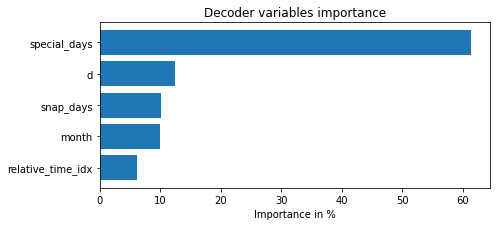

In [25]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)